In [3]:
import shapefile
from shapely.geometry import shape, Point, mapping
import numpy as np
import pandas as pd
import sys
sys.path.append("../..")
from src.data import utils

base = "../../data/"
filename = "raw/2016_LGA_SHAPE/LGA_2016_AUST"

sf = shapefile.Reader(base+filename)

centroids = list(map(lambda x: shape(x.__geo_interface__).centroid, sf.shapes()[:130]))

df = pd.DataFrame(sf.records())
nswdf = df[df[4] =="New South Wales"]
# drop "No usual address" - not a useful LGA
nswdf = nswdf[nswdf[0] != "LGA19499"]
nswdf.columns = ["code", "codenum", "name", "unknown", "state", "unknown2"]
nswdf["clean_name"] = nswdf["name"].str.extract('([^\\(]*)', expand=False).str.strip()
nswdf['long'] = np.asarray([x.x for x in centroids])
nswdf['lat'] = np.asarray([x.y for x in centroids])
nswdf

,code,codenum,name,unknown,state,unknown2,clean_name,long,lat
0,LGA10050,10050,Albury (C),1,New South Wales,305.9459,Albury,146.970424,-36.026604
1,LGA10130,10130,Armidale Regional (A),1,New South Wales,8620.6990,Armidale Regional,151.829150,-30.336349
2,LGA10250,10250,Ballina (A),1,New South Wales,484.9389,Ballina,153.486147,-28.852885
3,LGA10300,10300,Balranald (A),1,New South Wales,21690.6753,Balranald,143.611623,-33.950350
4,LGA10470,10470,Bathurst Regional (A),1,New South Wales,3817.8646,Bathurst Regional,149.525634,-33.430139
5,LGA10550,10550,Bega Valley (A),1,New South Wales,6278.8811,Bega Valley,149.717569,-36.825941
6,LGA10600,10600,Bellingen (A),1,New South Wales,1600.4337,Bellingen,152.728589,-30.403803
7,LGA10650,10650,Berrigan (A),1,New South Wales,2065.7759,Berrigan,145.711213,-35.734325
8,LGA10750,10750,Blacktown (C),1,New South Wales,240.0487,Blacktown,150.864351,-33.741329
9,LGA10800,10800,Bland (A),1,New South Wales,8557.6535,Bland,146.961268,-33.894344


In [2]:
#average distance between nearest neighbours
dist = []
for i in centroids:
    alldist = []
    for j in centroids:
        if i != j:
            alldist.append(i.distance(j))
    dist.append(np.min(alldist))
    
np.mean(dist)

0.46813379855385656

In [3]:
target = utils.r
target.columns

Index(['Year', 'Type', 'LGA', 'Assault - domestic violence',
       'Assault - non-domestic violence', 'Sexual Offences', 'Robbery',
       'Break and enter dwelling', 'Break and enter non-dwelling',
       'Motor vehicle theft', 'Steal from motor vehicle',
       'Steal from retail store', 'Steal from dwelling', 'Steal from person',
       'Fraud', 'Malicious damage to property', 'Harassment threatening',
       'Receiving stolen goods', 'Other theft', 'Arson',
       'Possession use of cannabis', 'Prohibited weapons offences', 'Trespass',
       'Offensive conduct', 'Offensive language', 'Liquor offences',
       'Breach AVO', 'Breach bail conditions', 'Resist or hinder officer',
       'Transport regulatory offences'],
      dtype='object')

In [4]:
#to get 2016 population, we divide total by rate
total_assault = target.loc[(target["Year"] == 2016) & (target["Type"] == "Total")]["Assault - domestic violence"]
rate_assault = target.loc[(target["Year"] == 2016) & (target["Type"] == "Rate per 100,000 population")]["Assault - domestic violence"].fillna(10000000)

population = np.divide(total_assault.values,rate_assault.values) * 100000
lga_names = target[["LGA"]][:130]
lga_names["pop"] = population

lga_names

,LGA,pop
0,Albury,52165.003785
1,Armidale Regional,30311.000839
2,Ballina,42625.995992
3,Balranald,0.050000
4,Bathurst Regional,42388.998368
5,Bayside,164879.992050
6,Bega Valley,33946.005356
7,Bellingen,12892.999209
8,Berrigan,8572.001671
9,Blacktown,347591.014251


In [88]:
# impute with 1, 0 is bad for log

for i, lower in enumerate(class_boundaries):
    lower_ix = lga_names["pop"] >= lower
    if i < len(class_boundaries) - 1:
        final_ix = (lga_names["pop"] < class_boundaries[i+1]) & lower_ix
    else:
        final_ix = lower_ix
        
    lga_names.loc[final_ix,"pop_class"] = i
    
nswdf_target = pd.merge(nswdf, target, left_on='clean_name', right_on='LGA').merge(lga_names, left_on="clean_name", right_on="LGA")
nswdf_target.rename(columns={"LGA_y": "LGA"}, inplace=True)
nswdf_target = nswdf_target.fillna(value=0.1)
# log it
start_col = nswdf_target.columns.get_loc('Assault - domestic violence')
for i in range(27):
    nswdf_target = nswdf_target.replace(0.0, 0.1)
    nswdf_target.iloc[:,start_col+i] = np.log(nswdf_target.iloc[:,start_col+i])
    
#get classes for stratification
class_boundaries = [0] + [nswdf_target["pop"].quantile(x) for x in (np.asarray(range(20, 100, 20)) / 100)]


    
#print(nswdf_target["pop_class"])
#nswdf_target["pop_class"].hist()

nswdf_target.to_csv(base+"processed/cleaned_log_target.csv")

In [89]:
nswdf_target.columns

Index(['code', 'codenum', 'name', 'unknown', 'state', 'unknown2', 'clean_name',
       'long', 'lat', 'Year', 'Type', 'LGA_x', 'Assault - domestic violence',
       'Assault - non-domestic violence', 'Sexual Offences', 'Robbery',
       'Break and enter dwelling', 'Break and enter non-dwelling',
       'Motor vehicle theft', 'Steal from motor vehicle',
       'Steal from retail store', 'Steal from dwelling', 'Steal from person',
       'Fraud', 'Malicious damage to property', 'Harassment threatening',
       'Receiving stolen goods', 'Other theft', 'Arson',
       'Possession use of cannabis', 'Prohibited weapons offences', 'Trespass',
       'Offensive conduct', 'Offensive language', 'Liquor offences',
       'Breach AVO', 'Breach bail conditions', 'Resist or hinder officer',
       'Transport regulatory offences', 'LGA', 'pop', 'pop_class'],
      dtype='object')

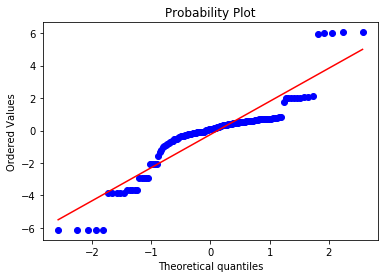

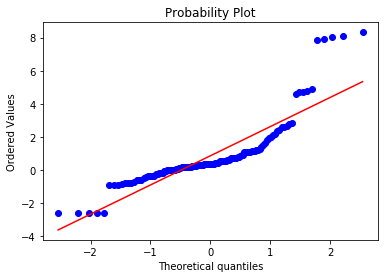

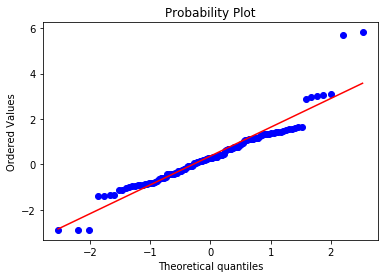

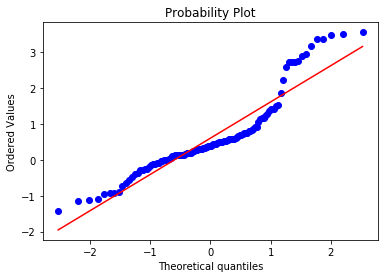

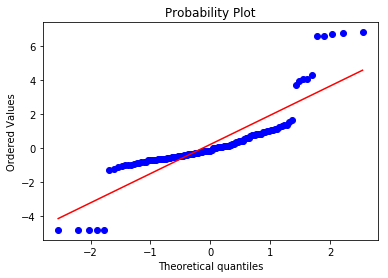

[2.1792553597970836,
 2.154174230377247,
 1.3565212718823303,
 1.2193097233883763,
 1.9468081388584313]

In [95]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.stats import probplot

from matplotlib import pyplot as plt

def kfold_cv(k, crimenum, dataframe):
    start_col = dataframe.columns.get_loc('Assault - domestic violence')
    skf = StratifiedKFold(k)
    
    mus = []
    sigmas = []
    rmse = []
    
    output = pd.DataFrame(index=range(len(dataframe)))
    for train_index, test_index in skf.split(lga_names, lga_names["pop_class"]):
        train_lgas = lga_names.iloc[train_index, lga_names.columns.get_loc("LGA")]
        traindf = dataframe.loc[dataframe["LGA"].isin(train_lgas)]
        
        test_lgas = lga_names.iloc[test_index, lga_names.columns.get_loc("LGA")]
        testdf = dataframe.loc[dataframe["LGA"].isin(test_lgas)]
        #import pdb; pdb.set_trace()
        model = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1) + 1.0 * WhiteKernel(), normalize_y=False)
        model.fit(traindf[['lat','long']], traindf.iloc[:,start_col+crimenum])
        lga_loc = np.asarray(testdf[['lat','long']])
        #print(lga_loc)
        mu, sigma = model.predict(lga_loc, return_std=True)
        mus.append(mu)
        sigmas.append(sigma)
        #is this a fair measure
        rmse.append(np.sqrt(mean_squared_error(mu, testdf.iloc[:,start_col+crimenum])))
        probplot(testdf.iloc[:,start_col+crimenum] - mu, dist='norm', plot=plt)
        plt.show()

    return output, rmse

output = kfold_cv(5, 0, nswdf_target.loc[(nswdf_target["Type"] == "Rate per 100,000 population")])
output[1]                                     

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
#trains a model with all but the given LGA and plots teh conditional distribution on its centroid for given crimetype
def plot_conditional(lga, crimetype):
    model = GaussianProcessRegressor(normalize_y=True)
    loo_row_indexer = nswdf_target['clean_name']!=lga
    model.fit(nswdf_target.loc[loo_row_indexer, ['lat','long']], nswdf_target.loc[loo_row_indexer,nswdf_target.columns[start_col+i]])
    lga_loc = np.asarray(nswdf_target.loc[nswdf_target['clean_name']==lga, ['lat', 'long']].iloc[0]).reshape([1,2])
    mu, sigma = model.predict(lga_loc, return_std=True)

    x = np.linspace(-3, 8, 1000)
    plt.plot(x,mlab.normpdf(x, mu, sigma))
    plt.scatter(x=nswdf_target.loc[nswdf_target['clean_name']==lga, crimetype], y=np.zeros(5), color='red')
    
plot_conditional('Willoughby', 'Assault - non-domestic violence')